# Portfolio Construction 2-- Returns and Risk Analysis

## Objectives
1. Analyze the returns and risk of the dataset obtained in notebook 1
2. Create analysis functions

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import sys
sys.path.insert(0, 'python_files')
import functions_1 as fnc
import edhec_risk_kit_127 as erk


In [2]:
tickers = fnc.avail_tickers()
#r = fnc.get_returns_data(tickers=tickers, max_period=True, interval='1d', file_directory='Data/cleaned_data/historical_returns_data_1.csv', index_freq='D')

#Now as we have exported the file to local computer now I will use that file for further analysis so that we don't have to call yfinance too many times

r = pd.read_csv('Data/cleaned_data/historical_returns_data_1.csv', index_col='Date')
r = pd.DataFrame(data=r)
r.index = pd.to_datetime(r.index)

In [3]:
def start_dates(r):
    """
    returns a dictionary containing the start date of a historical asset returns dataframe, useful in knowing data vailable for each asset
    """
    columns = r.columns.tolist()
    start_dates = {}
    for column in columns:
        index = r[column].dropna().index
        start_date = min(index)
        start_dates[column] = start_date
    sorted_start_dates = dict(sorted(start_dates.items(), key=lambda item: item[1]))
    return sorted_start_dates

In [4]:
start_dates(r)

{'S&P 500': Timestamp('1928-01-03 00:00:00'),
 'Vanguard High Yield Corporate Fund': Timestamp('1980-01-03 00:00:00'),
 'Vanguard Small Cap Index Fund': Timestamp('1980-01-03 00:00:00'),
 'Vanguard Value Index Fund': Timestamp('1992-11-02 00:00:00'),
 'SPDR S&P 500 ETF Trust': Timestamp('1993-02-01 00:00:00'),
 'Vanguard Total Intl Stock Idx Fund': Timestamp('1996-04-30 00:00:00'),
 'Vanguard Mid Cap Index Fund': Timestamp('1998-05-22 00:00:00'),
 'Vanguard Small Cap Value Index Fund': Timestamp('1998-05-22 00:00:00'),
 'Vanguard Real Estate Index Fund': Timestamp('2004-09-30 00:00:00'),
 'SPDR Gold Shares': Timestamp('2004-11-19 00:00:00'),
 'Vanguard Emerging Markets Stock Index Fund': Timestamp('2005-03-11 00:00:00'),
 'iShares J.P. Morgan USD Emerging Markets Bond ETF': Timestamp('2007-12-20 00:00:00')}

In [5]:
r = r.dropna()
r_w = fnc.change_timeframe(r, Timeframe='W')
r_m = fnc.change_timeframe(r, Timeframe='M')

```python
def semi_deviation(r):
    """
    Returns the semideviation of the given Series or Datarame of returns
    """
    is_negative = r < 0
    return r[is_negative].std(ddof=0)
```

In [6]:
fnc.semi_deviation(r_m)

Vanguard High Yield Corporate Fund                   0.003092
Vanguard Total Intl Stock Idx Fund                   0.028534
Vanguard Mid Cap Index Fund                          0.037011
S&P 500                                              0.033379
Vanguard Value Index Fund                            0.023269
Vanguard Small Cap Value Index Fund                  0.037591
Vanguard Small Cap Index Fund                        0.035511
iShares J.P. Morgan USD Emerging Markets Bond ETF    0.026825
Vanguard Emerging Markets Stock Index Fund           0.036945
Vanguard Real Estate Index Fund                      0.036231
SPDR S&P 500 ETF Trust                               0.024994
SPDR Gold Shares                                     0.029866
dtype: float64

In [7]:
from typing import Union

def drawdown(r: Union[pd.Series, pd.DataFrame]):
    """
    Takes a DataFrame or series of asset returns.
    Returns a DataFrame with nested columns for each asset, containing the wealth index, the previous peaks, and the percentage drawdown.
    """
    wealth_indices = 1000 * (1 + r).cumprod()
    previous_peaks = wealth_indices.cummax()
    drawdowns = (wealth_indices - previous_peaks) / previous_peaks

    if isinstance(r, pd.DataFrame):
        # Create a MultiIndex for nested columns
        columns = pd.MultiIndex.from_product([r.columns, ["Wealth", "Previous Peak", "Drawdown"]])

        # Create the result DataFrame with the nested columns
        result_df = pd.DataFrame(columns=columns, index=r.index)

        # Fill in the data for each asset
        for column in r.columns:
            result_df[(column, "Wealth")] = wealth_indices[column]
            result_df[(column, "Previous Peak")] = previous_peaks[column]
            result_df[(column, "Drawdown")] = drawdowns[column]
    else:
        wealth_index = 1000*(1+r).cumprod()
        previous_peaks = wealth_index.cummax()
        drawdowns = (wealth_index - previous_peaks)/previous_peaks
        return pd.DataFrame({"Wealth": wealth_index, 
                             "Previous Peak": previous_peaks, 
                             "Drawdown": drawdowns})
    
    return result_df

In [8]:
dr = drawdown(r_m)
dr.head()

Vanguard High Yield Corporate Fund                         \
                                    Wealth Previous Peak Drawdown   
Date                                                                
2007-12                        1002.302430   1002.302430      0.0   
2008-01                        1003.163130   1003.163130      0.0   
2008-02                        1003.200880   1003.200880      0.0   
2008-03                        1004.484048   1004.484048      0.0   
2008-04                        1009.306480   1009.306480      0.0   

        Vanguard Total Intl Stock Idx Fund                          \
                                    Wealth Previous Peak  Drawdown   
Date                                                                 
2007-12                        1058.182214   1058.182214  0.000000   
2008-01                         984.430461   1058.182214 -0.069697   
2008-02                         988.251762   1058.182214 -0.066085   
2008-03                         984.659413   1058.182214 -0.069480   
2008-04                        1030.111354   1058.182214 -0.026527   

        Vanguard Mid Cap Index Fund                              S&P 500  ...  \
                             Wealth Previous Peak  Drawdown       Wealth  ...   
Date                                                                      ...   
2007-12                 1014.397502   1014.397502  0.000000  1010.825575  ...   
2008-01                  953.080040   1014.397502 -0.060447   949.486787  ...   
2008-02                  934.339735   1014.397502 -0.078921   917.441831  ...   
2008-03                  919.639097   1014.397502 -0.093413   914.835072  ...   
2008-04                  976.530966   1014.397502 -0.037329   958.642069  ...   

        Vanguard Emerging Markets Stock Index Fund  \
                                          Drawdown   
Date                                                 
2007-12                                   0.000000   
2008-01                                  -0.084081   
2008-02                                  -0.057360   
2008-03                                  -0.082828   
2008-04                                  -0.011831   

        Vanguard Real Estate Index Fund                          \
                                 Wealth Previous Peak  Drawdown   
Date                                                              
2007-12                     1025.088658   1025.088658  0.000000   
2008-01                     1023.919990   1025.088658 -0.001140   
2008-02                     1002.245819   1025.088658 -0.022284   
2008-03                     1063.422505   1063.422505  0.000000   
2008-04                     1114.593995   1114.593995  0.000000   

        SPDR S&P 500 ETF Trust                         SPDR Gold Shares  \
                        Wealth Previous Peak  Drawdown           Wealth   
Date                                                                      
2007-12            1012.286285   1012.286285  0.000000      1040.343483   
2008-01             962.610902   1012.286285 -0.049072      1149.406840   
2008-02             943.187574   1012.286285 -0.068260      1209.898666   
2008-03             943.146316   1012.286285 -0.068301      1139.001765   
2008-04             978.986791   1012.286285 -0.032895      1093.593650   

                                 
        Previous Peak  Drawdown  
Date                             
2007-12   1040.343483  0.000000  
2008-01   1149.406840  0.000000  
2008-02   1209.898666  0.000000  
2008-03   1209.898666 -0.058597  
2008-04   1209.898666 -0.096128  

[5 rows x 36 columns]

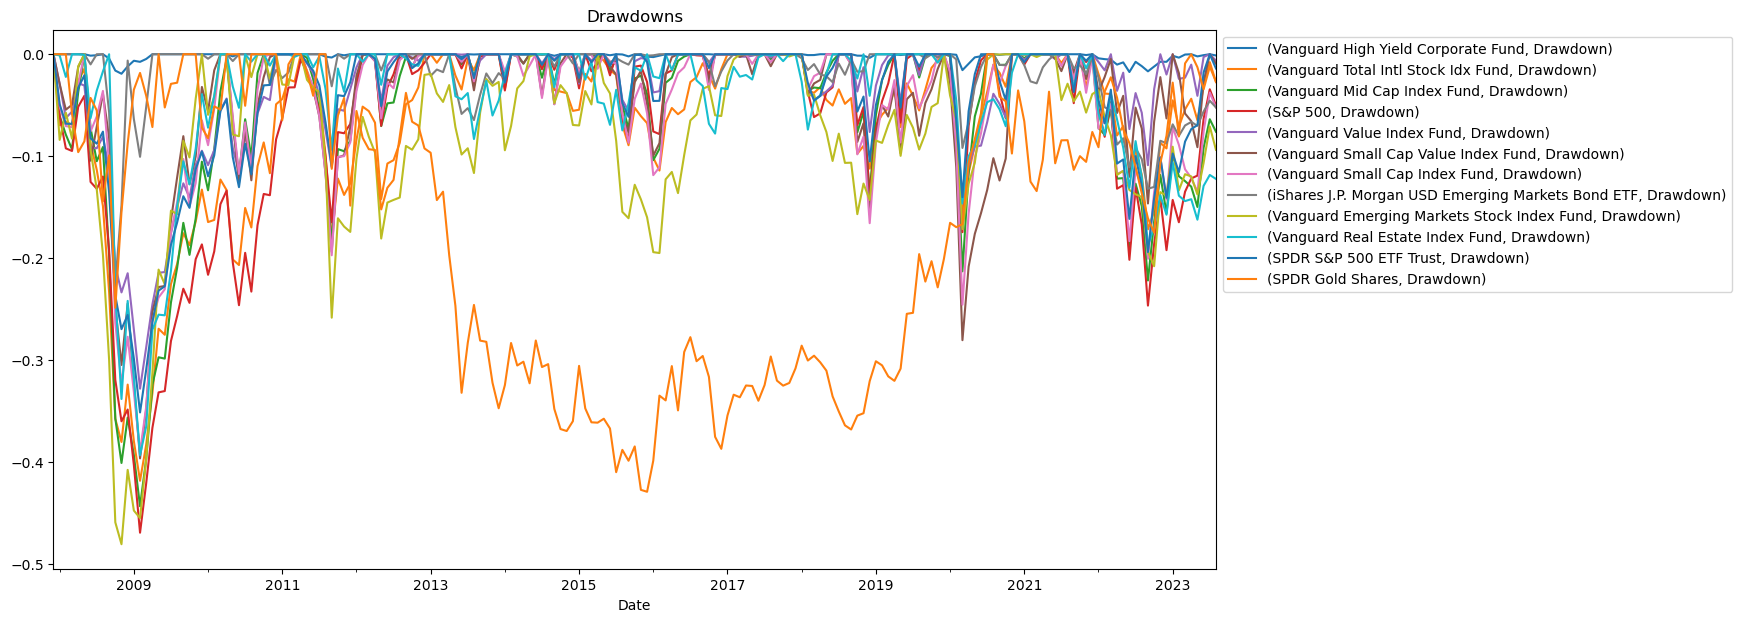

In [9]:
dr.loc[:, (slice(None), 'Drawdown')].plot(figsize=(15,7), title='Drawdowns')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

<Axes: title={'center': 'Wealth Growth'}, xlabel='Date'>

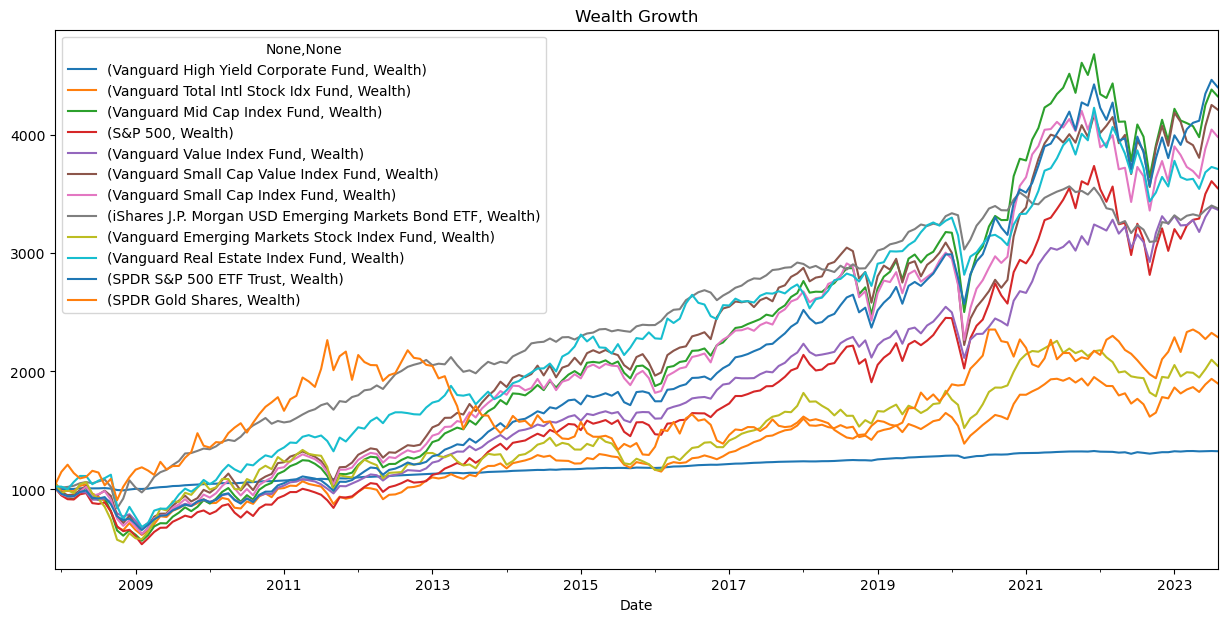

In [10]:
dr.loc[:, (slice(None), 'Wealth')].plot(figsize=(15,7), title='Wealth Growth')

In [11]:
def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Computes the annualized sharpe ratio of a set of returns
    """
    # convert the annual riskfree rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = fnc.annualize_returns(excess_ret, periods_per_year)
    ann_vol = fnc.annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol

<Axes: title={'center': 'Sharpe Ratios'}>

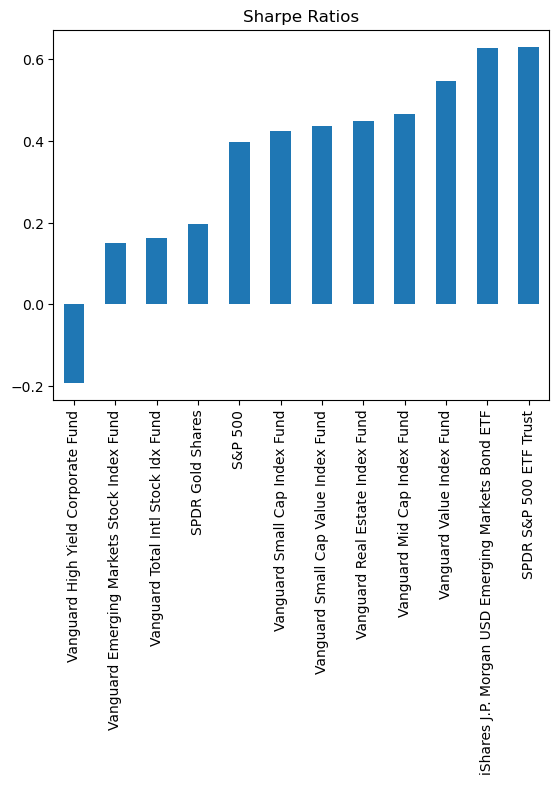

In [12]:
sharpe_ratio(r_m, riskfree_rate=0.02, periods_per_year=12).sort_values().plot.bar(title='Sharpe Ratios')

<Axes: title={'center': 'Annualized Returns'}>

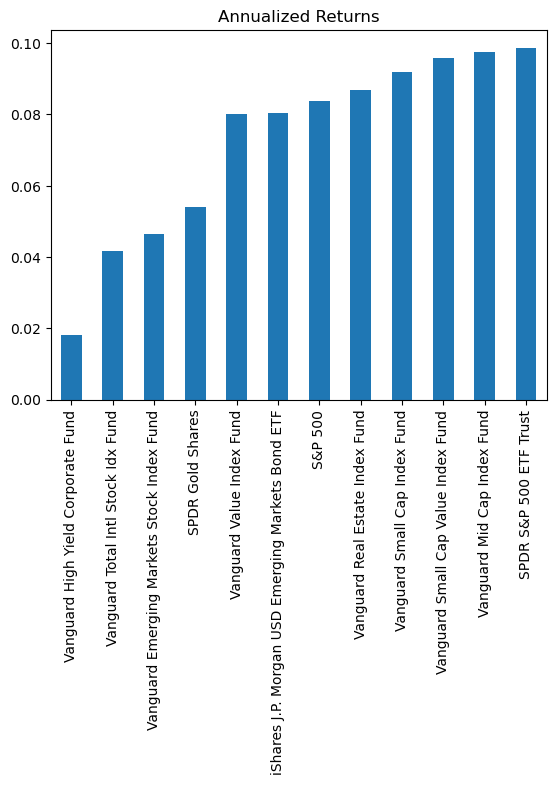

In [13]:
fnc.annualize_returns(r_m, 12).sort_values().plot.bar(title='Annualized Returns')

<Axes: title={'center': 'Annualized Volatility'}>

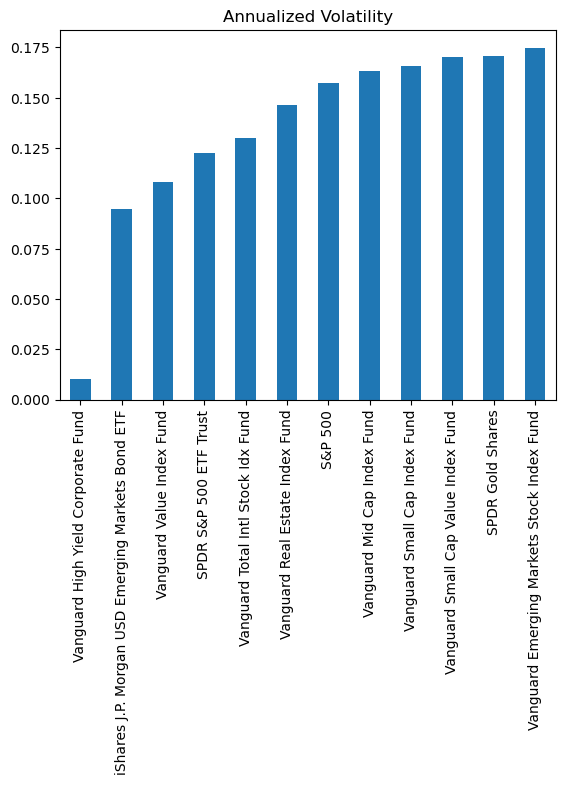

In [14]:
fnc.annualize_vol(r_m, 12).sort_values().plot.bar(title='Annualized Volatility')

In [15]:
fnc.skewness(r_m)

Vanguard High Yield Corporate Fund                  -1.458016
Vanguard Total Intl Stock Idx Fund                  -0.652810
Vanguard Mid Cap Index Fund                         -0.743073
S&P 500                                             -0.554664
Vanguard Value Index Fund                           -0.616723
Vanguard Small Cap Value Index Fund                 -0.706988
Vanguard Small Cap Index Fund                       -0.608119
iShares J.P. Morgan USD Emerging Markets Bond ETF   -0.668854
Vanguard Emerging Markets Stock Index Fund          -0.439582
Vanguard Real Estate Index Fund                     -1.115407
SPDR S&P 500 ETF Trust                              -0.591874
SPDR Gold Shares                                    -0.069788
dtype: float64

In [16]:
fnc.kurtosis(r_m)

Vanguard High Yield Corporate Fund                   10.046657
Vanguard Total Intl Stock Idx Fund                    4.956832
Vanguard Mid Cap Index Fund                           4.970537
S&P 500                                               3.698355
Vanguard Value Index Fund                             4.038034
Vanguard Small Cap Value Index Fund                   5.018384
Vanguard Small Cap Index Fund                         4.496656
iShares J.P. Morgan USD Emerging Markets Bond ETF    20.116373
Vanguard Emerging Markets Stock Index Fund            5.827030
Vanguard Real Estate Index Fund                       9.485299
SPDR S&P 500 ETF Trust                                3.570893
SPDR Gold Shares                                      3.301757
dtype: float64

In [17]:
r.corr()

,Vanguard High Yield Corporate Fund,Vanguard Total Intl Stock Idx Fund,Vanguard Mid Cap Index Fund,S&P 500,Vanguard Value Index Fund,Vanguard Small Cap Value Index Fund,Vanguard Small Cap Index Fund,iShares J.P. Morgan USD Emerging Markets Bond ETF,Vanguard Emerging Markets Stock Index Fund,Vanguard Real Estate Index Fund,SPDR S&P 500 ETF Trust,SPDR Gold Shares
Vanguard High Yield Corporate Fund,1.000000,0.312940,0.313496,0.304559,0.295215,0.288205,0.312623,0.323933,0.232558,0.222442,0.317706,0.046701
Vanguard Total Intl Stock Idx Fund,0.312940,1.000000,0.871608,0.874966,0.855315,0.817289,0.828847,0.353153,0.896842,0.682543,0.871282,0.142495
Vanguard Mid Cap Index Fund,0.313496,0.871608,1.000000,0.968372,0.944943,0.950131,0.969764,0.335893,0.818330,0.803508,0.959892,0.049945
S&P 500,0.304559,0.874966,0.968372,1.000000,0.966010,0.909213,0.928552,0.322821,0.816334,0.778588,0.991893,0.033542
Vanguard Value Index Fund,0.295215,0.855315,0.944943,0.966010,1.000000,0.927824,0.915508,0.309844,0.787819,0.785633,0.956370,0.012957
Vanguard Small Cap Value Index Fund,0.288205,0.817289,0.950131,0.909213,0.927824,1.000000,0.982738,0.301424,0.755174,0.820816,0.897336,0.009562
Vanguard Small Cap Index Fund,0.312623,0.828847,0.969764,0.928552,0.915508,0.982738,1.000000,0.324272,0.763610,0.790527,0.922114,0.030755
iShares J.P. Morgan USD Emerging Markets Bond ETF,0.323933,0.353153,0.335893,0.322821,0.309844,0.301424,0.324272,1.000000,0.323801,0.243537,0.334324,0.141132
Vanguard Emerging Markets Stock Index Fund,0.232558,0.896842,0.818330,0.816334,0.787819,0.755174,0.763610,0.323801,1.000000,0.673352,0.805846,0.140048
Vanguard Real Estate Index Fund,0.222442,0.682543,0.803508,0.778588,0.785633,0.820816,0.790527,0.243537,0.673352,1.000000,0.755338,0.032609


In [18]:
r.corr().describe()

,Vanguard High Yield Corporate Fund,Vanguard Total Intl Stock Idx Fund,Vanguard Mid Cap Index Fund,S&P 500,Vanguard Value Index Fund,Vanguard Small Cap Value Index Fund,Vanguard Small Cap Index Fund,iShares J.P. Morgan USD Emerging Markets Bond ETF,Vanguard Emerging Markets Stock Index Fund,Vanguard Real Estate Index Fund,SPDR S&P 500 ETF Trust,SPDR Gold Shares
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,0.330865,0.708940,0.748823,0.741238,0.729787,0.721643,0.730776,0.359511,0.667809,0.632408,0.737000,0.139304
std,0.224595,0.278454,0.324036,0.328455,0.330489,0.330019,0.322959,0.209668,0.277020,0.296663,0.323355,0.275690
min,0.046701,0.142495,0.049945,0.033542,0.012957,0.009562,0.030755,0.141132,0.140048,0.032609,0.031901,0.009562
25%,0.274293,0.600195,0.686604,0.664647,0.666686,0.641736,0.653775,0.307739,0.585964,0.565898,0.650084,0.031615
50%,0.308591,0.842081,0.908276,0.892090,0.885412,0.859076,0.872178,0.323867,0.775714,0.766963,0.884309,0.040122
75%,0.314548,0.872448,0.962012,0.966601,0.947800,0.933400,0.938855,0.334716,0.816833,0.793772,0.957250,0.140319
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
